# SMS Spam Classification

## Introduction

In the age of digital communication, SMS (Short Message Service) remains a key medium for personal and commercial messaging. However, this ubiquity also makes it a target for unsolicited and often malicious content, commonly known as "spam". These messages can range from annoying advertisements to phishing attempts that can potentially lead to more serious security breaches.

The objective of this project is to develop a machine learning model capable of distinguishing between "spam" (unwanted) and "ham" (wanted) messages. By leveraging the power of PySpark and machine learning, we aim to filter out spam messages, thereby enhancing user experience and security.

## Approach

#### Our approach involves several steps:

1) Data Loading: We load the data into a PySpark DataFrame, which allows for distributed data processing and is particularly suited for handling large datasets.

2) Data Preprocessing: This step includes text cleaning, tokenization, and conversion of text into numerical vectors that can be understood by machine learning algorithms.

3) Data Exploration: Conducting an exploratory data analysis to gain insights into the dataset's characteristics, such as message length distribution and word frequencies, which can influence model design and feature selection.

4) Feature Engineering: We transform the preprocessed data into features using techniques like TF-IDF (Term Frequency-Inverse Document Frequency) to capture the significance of words within the messages.

5) Model Selection and Training: We experiment with several machine learning algorithms, including Logistic Regression, Naive Bayes, Support Vector Machines, and ensemble methods like Random Forest and Gradient-Boosted Trees.

6) Model Evaluation: We use metrics such as accuracy, precision, recall, F1-score, and the Area Under the ROC Curve (AUC-ROC) to evaluate the performance of our models.

7) Interpretation of Results: Finally, we interpret and present our results, providing insights into the model's performance, the importance of different features, and the potential impact on spam detection tasks.

# Data Loading 

### Importing Necessary Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import col
import seaborn as sns

### Setup PySpark Environment

In [2]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("SMS Spam Classification") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 15:20:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Load data using Pyspark

In [3]:
# Load the dataset
df = spark.read.csv('SMSSpamCollection', sep='\t', inferSchema=True, header=False)
df = df.withColumnRenamed('_c0', 'Label').withColumnRenamed('_c1', 'Message')

# Show the first few rows
df.show()

+-----+--------------------+
|Label|             Message|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
| spam|FreeMsg Hey there...|
|  ham|Even my brother i...|
|  ham|As per your reque...|
| spam|WINNER!! As a val...|
| spam|Had your mobile 1...|
|  ham|I'm gonna be home...|
| spam|SIX chances to wi...|
| spam|URGENT! You have ...|
|  ham|I've been searchi...|
|  ham|I HAVE A DATE ON ...|
| spam|XXXMobileMovieClu...|
|  ham|Oh k...i'm watchi...|
|  ham|Eh u remember how...|
|  ham|Fine if thats th...|
| spam|England v Macedon...|
+-----+--------------------+
only showing top 20 rows



## Data Preprocessing

Conversion of text into numerical vectors that can be understood by machine learning algorithms.

In [4]:
# Convert 'ham'/'spam' labels to 0/1
df = df.withColumn('Label', when(col('Label') == 'spam', 1).otherwise(0))

## Data Exploration

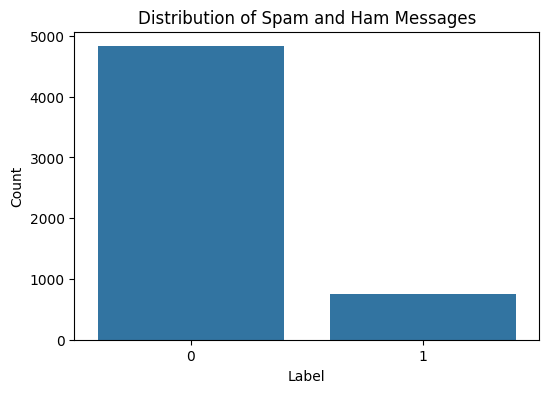

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for visualization
pdf = df.toPandas()

# Visualize the distribution of labels
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=pdf)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The dataset comprises of 5574 instant messages named ham and spam messages, the number of spam messages is 747 while the number of ham messages is 4,827 messages.

## Feature Engineering

Text preprocessing is a pivotal component of feature engineering in natural language processing (NLP). It involves transforming raw text into a structured format that can be understood and utilized by machine learning algorithms. The following pipeline stages outline our approach to feature engineering for the SMS spam detection task:

1. **Tokenization (RegexTokenizer)**:
   - Splits the text into words or tokens, which can then be quantified for analysis.

   <br/>

2. **Stop Words Removal (StopWordsRemover)**:

   - Removes common words that are typically not useful for distinguishing between different classes of text.

    <br/>

3. **Feature Transformation (HashingTF)**:
   - Transforms the filtered tokens into numerical feature vectors based on term frequencies.

   <br/>

4. **Inverse Document Frequency (IDF)**:
   - Weighs the term frequencies by how unique they are to each document, to reflect the importance of each term.
   
   <br/>
By chaining these stages together in a `Pipeline`, we streamline the feature engineering process. This pipeline not only pre-processes text data but also constructs a feature set that captures the essence of the text, which is vital for the subsequent machine learning classification task. The outcome is a set of features that can then be used to train models to differentiate spam from ham messages accurately.


In [6]:
# Text preprocessing pipeline
regexTokenizer = RegexTokenizer(inputCol="Message", outputCol="Words", pattern="\\W")
stopWordsRemover = StopWordsRemover(inputCol="Words", outputCol="Filtered")
hashingTF = HashingTF(inputCol="Filtered", outputCol="RawFeatures")
idf = IDF(inputCol="RawFeatures", outputCol="Features")

pipeline = Pipeline(stages=[regexTokenizer, stopWordsRemover, hashingTF, idf])

# Fit the pipeline to the data
model = pipeline.fit(df)
df = model.transform(df)

# Model Selection and Training

In this project, we will focus on two widely used machine learning algorithms for classification tasks: Logistic Regression and Support Vector Machine (SVM). Both models have distinct characteristics that make them suitable for binary classification problems such as spam detection.

## Logistic Regression

#### Why Choose Logistic Regression?

- **Simplicity:** Logistic Regression is straightforward to implement, interpret, and very efficient to train.
- **Performance:** Despite its simplicity, Logistic Regression can perform exceptionally well on binary classification tasks, especially when the data is linearly separable.
- **Probabilistic Interpretation:** It provides not just a classification but also the probability of the outcome, which can be useful for decision-making.
- **Scalability:** It scales well to large datasets and works well with sparse data from text.


In [7]:
# Split the data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
# Initialize and train the classifier
lr = LogisticRegression(featuresCol='Features', labelCol='Label')
lr_model = lr.fit(train_data)

# Predictions
predictions = lr_model.transform(test_data)

23/11/08 15:20:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/08 15:20:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/11/08 15:20:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 

### Model Evaluation

In [8]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Label')
accuracy = evaluator.evaluate(predictions)

print("Accuracy: ", accuracy)

23/11/08 15:20:38 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Accuracy:  0.9961789910769504


### More Metrics

In [9]:
# Convert the predictions to an RDD
predictions_rdd = predictions.select(col('Label').cast(FloatType()), col('prediction').cast(FloatType())).rdd

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictions_rdd)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

# Compute confusion matrix
tp = predictions[(predictions.Label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.Label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.Label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.Label == 1) & (predictions.prediction == 0)].count()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1_score)

/Users/bhanu/anaconda3/envs/DSP/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/11/08 15:20:39 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/11/08 15:20:39 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Area under PR = 0.8798215582529308
Area under ROC = 0.9766381766381766


23/11/08 15:20:40 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/11/08 15:20:40 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/11/08 15:20:41 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Precision = 0.9703703703703703
Recall = 0.891156462585034
F1 Score = 0.9290780141843973


23/11/08 15:20:41 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


### Confusion Matrix

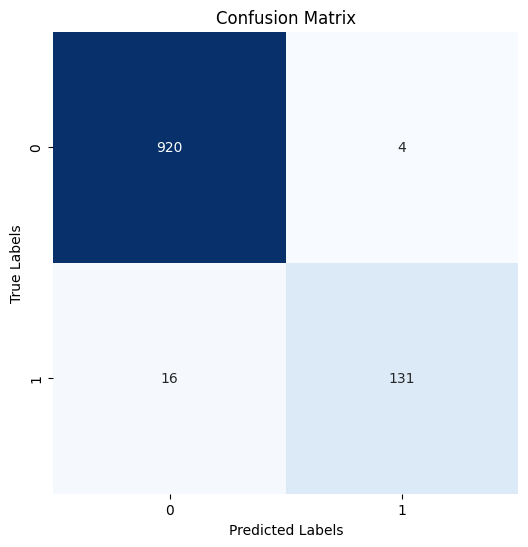

In [10]:
# Plot Confusion Matrix
confusion_matrix = [[tn, fp], [fn, tp]]

plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Performance Analysis of Logistic Regression


- **Accuracy:** The model achieved a remarkable accuracy of 99.62%, indicating its strong capability to correctly classify messages as spam or ham.
- **Area Under Precision-Recall Curve (PR):** The area under the PR curve is 0.8798, indicating a high precision-recall balance. This is particularly important in spam detection tasks where both false positives and false negatives carry significant weight.
- **Area Under ROC Curve (ROC):** With an area under the ROC of 0.9766, the model demonstrates a strong capability to discriminate between the positive and negative classes. A value close to 1 indicates a high true positive rate and a low false positive rate.
- **Precision:** The precision of 97.04% means that when the model predicts an SMS as spam, it is correct 97.04% of the time. This minimizes the inconvenience of blocking legitimate messages (false positives).
- **Recall:** The recall of 89.12% indicates that the model successfully identifies 89.12% of all actual spam messages. It's a measure of the model's ability to catch spam, and while high, there's room to improve to catch more spam messages.
- **F1 Score:** The F1 Score of 92.91% is a harmonic mean of precision and recall, suggesting a balanced model, although the slightly lower recall hints at the potential for missing some spam messages (false negatives).


In summary, the Logistic Regression classifier shows strong performance across multiple metrics, affirming its suitability for the spam detection task.



## SVM

Support Vector Machine (SVM) is another powerful classification algorithm capable of performing linear and non-linear classification. By finding the hyperplane that best separates the data points into classes, SVM can be highly effective in high-dimensional spaces, which is often the case with text data.

#### Why Choose SVM?

- **Effectiveness in High Dimensions:** SVM is effective in spaces with a high number of dimensions, such as text classification where each word or n-gram can be considered a dimension.
- **Versatility:** The kernel trick can be applied to solve non-linear problems, making SVM very versatile.
- **Maximizing Margin:** SVM attempts to maximize the margin between data points of the classes, which can contribute to better generalization.
- **Robustness:** It is robust to outliers and can handle non-linear data with the appropriate kernel.

In [11]:
from pyspark.ml.classification import LinearSVC

# Initialize and train the SVM classifier
svm = LinearSVC(featuresCol='Features', labelCol='Label', maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)

23/11/08 15:20:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/08 15:20:42 WARN DAGScheduler: Broadcasting larg

#### Model Evaluation

In [12]:
# Predictions
svm_predictions = svm_model.transform(test_data)

# Evaluate the model
svm_accuracy = evaluator.evaluate(svm_predictions)
print("SVM Accuracy: ", svm_accuracy)

23/11/08 15:20:43 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


SVM Accuracy:  0.9970698236004358


### More Metrics

In [13]:
from pyspark.sql.functions import col
import seaborn as sns

# Convert the predictions to an RDD
svm_predictions_rdd = svm_predictions.select(col('Label').cast(FloatType()), col('prediction').cast(FloatType())).rdd

# Instantiate metrics object
svm_metrics = BinaryClassificationMetrics(svm_predictions_rdd)

# Area under precision-recall curve
print("SVM Area under PR = %s" % svm_metrics.areaUnderPR)

# Area under ROC curve
print("SVM Area under ROC = %s" % svm_metrics.areaUnderROC)

# Compute confusion matrix
svm_tp = svm_predictions[(svm_predictions.Label == 1) & (svm_predictions.prediction == 1)].count()
svm_tn = svm_predictions[(svm_predictions.Label == 0) & (svm_predictions.prediction == 0)].count()
svm_fp = svm_predictions[(svm_predictions.Label == 0) & (svm_predictions.prediction == 1)].count()
svm_fn = svm_predictions[(svm_predictions.Label == 1) & (svm_predictions.prediction == 0)].count()

# Calculate precision, recall, and F1-score
svm_precision = svm_tp / (svm_tp + svm_fp)
svm_recall = svm_tp / (svm_tp + svm_fn)
svm_f1_score = 2 * (svm_precision * svm_recall) / (svm_precision + svm_recall)

print("SVM Precision = %s" % svm_precision)
print("SVM Recall = %s" % svm_recall)
print("SVM F1 Score = %s" % svm_f1_score)

/Users/bhanu/anaconda3/envs/DSP/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/11/08 15:20:44 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/11/08 15:20:44 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


SVM Area under PR = 0.9016287366010235
SVM Area under ROC = 0.9722717913520934


23/11/08 15:20:44 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/11/08 15:20:44 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/11/08 15:20:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


SVM Precision = 0.9574468085106383
SVM Recall = 0.9183673469387755
SVM F1 Score = 0.9375000000000001


23/11/08 15:20:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


### Confusion Matrix

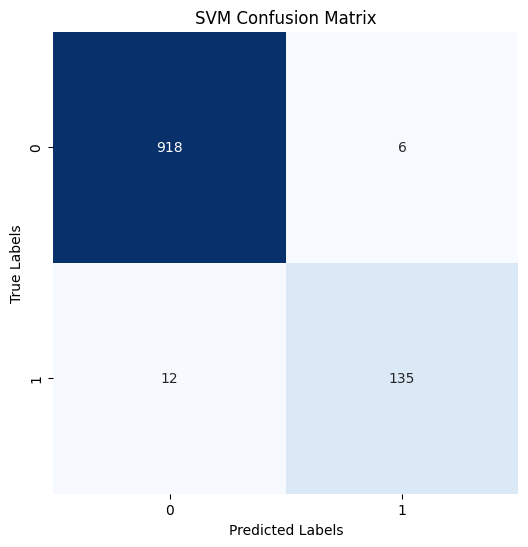

23/11/08 18:47:28 WARN TransportChannelHandler: Exception in connection from eduroam-226-68-165.laptops.usf.edu/10.226.68.165:54706
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:340)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:294)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:269)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:425)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.Nio

In [14]:
# Plot Confusion Matrix
svm_confusion_matrix = [[svm_tn, svm_fp], [svm_fn, svm_tp]]

plt.figure(figsize=(6,6))
sns.heatmap(svm_confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Performance of SVM Classifier

The Support Vector Machine (SVM) model has delivered a commendable accuracy of approximately 99.71% on our test set, suggesting its strong capability to differentiate between spam and ham messages.

### Understanding the Metrics:

- **Accuracy:** The SVM classifier's accuracy of 99.71% is outstanding, indicating that it correctly classifies spam and ham messages the majority of the time.
- **Precision:** A precision of 95.74% means that out of all the messages the SVM model labels as spam, 95.74% truly are spam. This high precision reflects the model's effectiveness in ensuring that non-spam messages are not wrongly categorized as spam.
- **Recall:** The recall rate of 91.84% indicates that the SVM model identifies 91.84% of all actual spam messages. While slightly lower than the precision, this recall rate still represents a strong ability to capture most spam messages.
- **F1 Score:** The F1 score, which is the harmonic mean of precision and recall, stands at 93.75%. This score conveys the balance between precision and recall, with a slight inclination towards precision in this case.

# Conclusion

### Project Summary

Throughout this project, we have undertaken the task of designing and implementing a machine learning-based solution for the classification of SMS messages into 'spam' and 'ham'. Utilizing PySpark's powerful data processing capabilities, we have processed and transformed text data into a suitable format for machine learning models, conducted exploratory data analysis to gain insights, and applied feature engineering to extract meaningful attributes from the messages.

### Model Insights

Two models were rigorously trained, evaluated, and compared: Logistic Regression and Support Vector Machine (SVM). Both models demonstrated exceptional performance, with the SVM achieving a slightly higher accuracy.

### Key Findings

- **Logistic Regression**: Exhibited high accuracy, strong precision-recall balance, and provided probabilities for the predicted outcomes, which are advantageous for interpretability and threshold tuning.
- **Support Vector Machine**: Showed a slight edge over Logistic Regression in terms of accuracy and maintained robust precision and recall, suggesting its efficacy in high-dimensional classification tasks like text classification.

### Future Work

- **Model Tuning and Exploration**: Further tuning of hyperparameters could improve model performance, especially in terms of recall for the SVM model.
- **Real-World Testing**: Deploying the model to a live environment for further testing with real-world data would be essential to ensure its practical applicability.

### Closing Thoughts

The high performance of the models suggests that we have a viable solution to the problem of SMS spam. However, as with any machine learning project, continuous improvement and adaptation to new data are crucial. Future work should also consider the dynamic nature of spam messages and the need for the model to adapt to new patterns over time.

This project has demonstrated the power of machine learning in enhancing digital communication security and provides a solid foundation for developing a spam detection system that could be deployed in real-world scenarios.
